# Keyspace size
- We want this to match the read activity (9K ops/second)
- Will this be affected by # of WMs?
- How much of this can we cache?

In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib, tarfile, shutil, os, glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline
from IPython.display import HTML
HTML('''<script> code_show=true; 
function code_toggle() {
 if (code_show){$('div.input').hide();}
 else {$('div.input').show();}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script> To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')                             

... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... 4 Hour ... DONE!


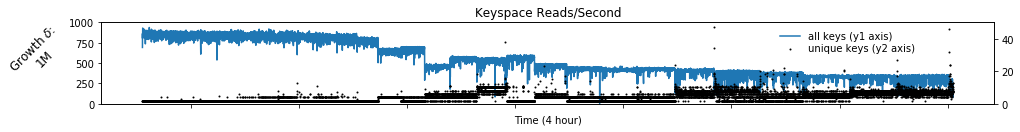

In [2]:
names = {"0": "Splicer", "1": "Worker", "2": "PersistentDB",
         "3": "InMemoryDB", "4": "WorkManager", -1: "all ranks"}

def untar(fname):
    try: shutil.rmtree("tmp")
    except: pass
    os.mkdir("tmp")
    tar = tarfile.open(fname)
    tar.extractall()
    tar.close()

### Boring Parsing Info
# The data structure we read into is a dictionary, where the key is a tuple that identifies the job and the 
# value is a tuple with parsed data in Python data frames. The `parse()` function reads the raw data and 
# puts it into the dictionary:
#
# dfs[(name, op, rank)] => {KEY TIMES, KEY COUNT}
#
# where `name` is a human readable string that describes the job, `op` is the type of database operation,
# `rank` is the MPI rank number, `KEY TIMES` has keys and timestamps, and `KEY COUNT` has keys and counts (i.e. # 
# of occurences). We save `countDF` because it takes forever to parse this data.
def parse(dfs, name, results):
    stats = []
    for rank in ["0", "1", "2", "3", "4"]:
        untar(results + "/out/semanticPerf." + rank + ".tar.gz")
        shutil.move("semanticPerf." + rank, "tmp/semanticPerf." + rank)
        for op in ["DBMemoryPut", "DBMemoryGet"]:
            os.system("cat tmp/semanticPerf." + rank + " | grep " + op + " > tmp/keyspace.log")
            df_op = pd.read_csv("tmp/keyspace.log", names=['ts', 'op', 'dbkey', 'key'])
            if len(df_op) == 0: 
                continue           
            dfs[(name, op, rank)] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = {}
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = {}
            dfs[(name, op, rank)]['DF_KEY_TIMES'] = df_op
            dfs[(name, op, rank)]['DF_KEY_COUNT'] = df_op.groupby('key').size().reset_index()
            dfs[(name, op, rank)]['DF_KEY_COUNT'].columns=['key', 'count']

            # print stats
            stat = dfs[(name, op, rank)]['DF_KEY_COUNT']
            hotK = stat.loc[stat['count'].idxmax()]
            stats.append(name + " " + op + " " + names[rank] + ": nkeys=" + str(len(stat['key']))
                         + ", hottest key=" + str(hotK[0]) + " (count=" + str(hotK[1]) + ")")
        print "...", name, 
    print "... DONE!"
    return stats

def plot_uniquekeys_per_ts(ax, dfs, key_tuple, ylim=800, shift=0):
    df = dfs[key_tuple]['DF_KEY_TIMES']            # get all timestamps for all keys
    
    df_t = df.groupby('ts').size().reset_index()   # throughput
    df_t.columns=['ts', 'count']
    
    df_u = df.drop_duplicates()                    # only find unique keys by dropping duplicates
    df_u = df_u.groupby('ts').size().reset_index() # for each time stamp, count the unique
    df_u.columns=['ts', 'count']
    
    ax.plot(df_t['ts'], df_t['count'], label="all keys (y1 axis)")
    ax2 = ax.twinx()
    ax2.scatter(df_u['ts'], df_u['count'], color='black', s=1, label="unique keys (y2 axis)")
    ax.set_ylim(0, 2000)
    ax2.set_ylim(0, 50)
    return ax2

dfs = {}
stats = []
d = "../experiments/baseline-trinitite/"
stats.append(parse(dfs, "4 Hour", d+"nano/parmsweep/scale-length-hr4-59971/"))

fig, ax = plt.subplots(1, 1, figsize=(16, 1.5))
ax2 = plot_uniquekeys_per_ts(ax, dfs, ("4 Hour", "DBMemoryGet", "4"))
ax.set_title("Keyspace Reads/Second")
ax.set_xticklabels([])
ax.set_xlabel("Time (4 hour)")
ax.set_ylabel(r'Growth $\delta$: ' + '\n1M', rotation=45, fontsize=12)
ax.yaxis.labelpad = 20
ax.set_ylim(0, 1000)
ax.legend(bbox_to_anchor=(0.75, 1), loc='upper left', frameon=False)
ax2.legend(bbox_to_anchor=(0.75, 0.85), loc='upper left', frameon=False)
plt.savefig("../paper/figures/keyspace-regimes-4hr.png", dpi=400, bbox_inches='tight')

In [3]:
stats

[['4 Hour DBMemoryPut Splicer: nkeys=51, hottest key=10313986423432176915 (count=1)',
  '4 Hour DBMemoryGet Splicer: nkeys=51, hottest key=13397889897772269455 (count=2)',
  '4 Hour DBMemoryPut InMemoryDB: nkeys=2173, hottest key=10002327738147764502 (count=1)',
  '4 Hour DBMemoryGet InMemoryDB: nkeys=2173, hottest key=10313986423432176915 (count=2)',
  '4 Hour DBMemoryPut WorkManager: nkeys=2178, hottest key=14045287823504495930 (count=100092)',
  '4 Hour DBMemoryGet WorkManager: nkeys=2193, hottest key=14045287823504495930 (count=300219)']]

In [4]:
untar(d+"nano/parmsweep/scale-length-hr4-59971/out/perf.tar.gz")

In [5]:
shutil.move("perf", "tmp/perf")

In [6]:
frame = pd.DataFrame()
list_ = []
for ts in range(1503107100, 1503122101):
    file_ = "tmp/perf/perf.1."+str(ts)
    if not os.path.exists(file_):
        continue
    df = pd.read_csv(file_, names=['op', 'count', 'ts'])
    list_.append(df)
    if ts % 1000 == 0:
        print str(ts), 
frame = pd.concat(list_)

1503108000 1503109000 1503110000 1503111000 1503112000 1503113000 1503114000 1503115000 1503116000 1503117000 1503118000 1503119000 1503120000 1503121000 1503122000


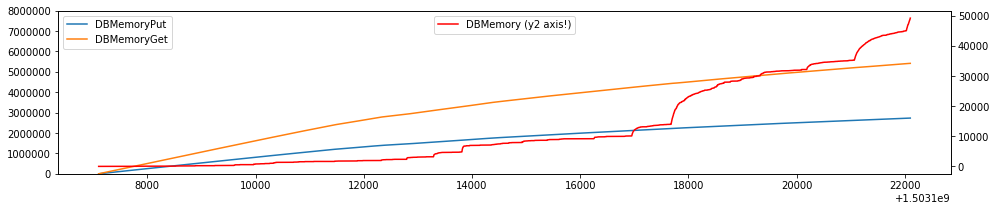

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))

df = frame[(frame['op'] == 'DBMemoryPut')]
ax.plot(df['ts'], df['count'], label='DBMemoryPut')

df = frame[(frame['op'] == 'DBMemory')]
ax2 = ax.twinx()
ax2.plot(df['ts'], df['count'], label='DBMemory (y2 axis!)', color='red')

df = frame[(frame['op'] == 'DBMemoryGet')]
ax.plot(df['ts'], df['count'], label='DBMemoryGet')
ax.set_ylim(0, 8000000)
ax.legend(loc='upper left'); ax2.legend(loc='upper center')

```cpp
int STLLocalDataStore::put(unsigned int dbKey, uint64_t &key, Rd &data){
        INC(DBMemoryPut);
        debug_perf("DBMemoryPut," << dbKey << "," << key);

        if( dbm.count(dbKey)==0 ) {
                return DBKEY_NOTFOUND;
        }
        bool allowDuplicates=dbAttributes[dbKey].first;

        if(allowDuplicates or count(dbKey, key)==0) {
                dbm[dbKey].insert(std::make_pair(key,data));
                storedKeys[dbKey].insert(key);
                size_t s = data.size();
                INC(DBMemory);
                ADD(DBMemorySize, s);
                currentSize+=s;
        }

        INC(DBMemoryMRU);
        debug_perf("DBMemoryMRUPut," << dbKey << "," << key);
        mru.touch(std::make_pair(dbKey,key));

        return 0;

};
```

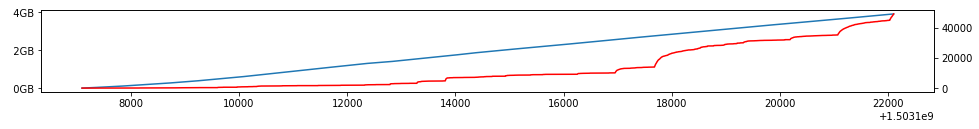

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(16, 1.5))
df = frame[(frame['op'] == 'DBMemorySize')]
ax.plot(df['ts'], df['count'])
df = frame[(frame['op'] == 'DBMemory')]
ax.twinx().plot(df['ts'], df['count'], color='red')
ax.set_yticklabels(['{:3.0f}GB'.format(yval/1000000000) for yval in ax.get_yticks()])

In [9]:
frame.head(13)

,op,count,ts
0,DBMemoryPut,0,1503107100
1,DBMemoryGet,0,1503107100
2,DBMemorySync,0,1503107100
3,DBMemory,0,1503107100
4,DBMemorySize,0,1503107100
5,DBMemoryMRU,0,1503107100
6,DriverPull,0,1503107100
7,DriverProc,0,1503107100
8,DriverPush,0,1503107100
9,ManagerSend,0,1503107100


### This needs to be verified
- 4GB seems awfully low
- 9K ops/second is bad!
- are keys truly never deleted?
- when does the WM start spilling?
- `uint64_t` is 16 bits: